# **1. Pretrained dataset (antiviral peptides)**

## **1.1 Processing two datasets separately**

In [1]:
import pandas as pd

def process_excel_file(file_path, sequence_column_name):
    # Read the Excel file into a Pandas DataFrame
    df = pd.read_excel(file_path)

    # Filter out rows containing only natural amino acids
    natural_amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    filtered_df = df[df[sequence_column_name].str.match('^[ACDEFGHIKLMNPQRSTVWY]+$')].copy()  # Add .copy() to avoid warnings

    # Drop duplicate rows based on 'Sequence' column
    filtered_df = filtered_df.drop_duplicates(subset=sequence_column_name)

    # Return the filtered DataFrame
    return filtered_df

# Process the first Excel file and store the result in df_AVPdb
df_AVPdb = process_excel_file('/content/AVPdb_data.xls', 'Sequence')

# Extract specific columns
columns_to_extract = ['Id', 'Sequence', 'Virus', 'Family', 'Inhibition/IC50', 'Unit', 'Target']
df_AVPdb_extracted = df_AVPdb.loc[:, columns_to_extract]

# Save extracted DataFrame to Excel
df_AVPdb_extracted.to_excel('df_AVPdb.xlsx', index=False)
print(df_AVPdb_extracted)

# Process the second Excel file and store the result in df_dravp
df_dravp = process_excel_file('/content/DRAVP_antiviral_peptides.xlsx', 'Sequence')

# Extract specific columns
columns_to_extract = ['DRAVP_ID', 'Sequence', 'Target_Organism', 'Family', 'Activity', 'Binding_Target', 'Mechanism']
df_dravp_extracted = df_dravp.loc[:, columns_to_extract]

# Save extracted DataFrame to Excel
df_dravp_extracted.to_excel('df_dravp.xlsx', index=False)
print(df_dravp_extracted)


           Id           Sequence                               Virus  \
0     AVP0001         PYVGSGLYRR          Avian myeloblastosis virus   
1     AVP0002          SMIENLEYM  Lymphocytic choriomeningitis virus   
2     AVP0003    ECRSTSYAGAVVNDL              Herpes simplex virus 1   
3     AVP0004       STSYAGAVVNDL              Herpes simplex virus 1   
4     AVP0005          YAGAVVNDL              Herpes simplex virus 1   
...       ...                ...                                 ...   
2045  AVP2049  LFGLIPSLIGGLVSAFK                       Measles virus   
2047  AVP2051        SLIGGLVSAFK                       Measles virus   
2048  AVP2052              VSAFK                       Measles virus   
2057  AVP2061       KHMHWHPPALNT                   Hepatitis B virus   
2058  AVP2062             SLIGRL                   Influenza A virus   

                Family Inhibition/IC50      Unit       Target  
0         Retroviridae              50        μM      Release  
1      

## **1.2 Merge two datasets and calculate the amino acid length distribution map**

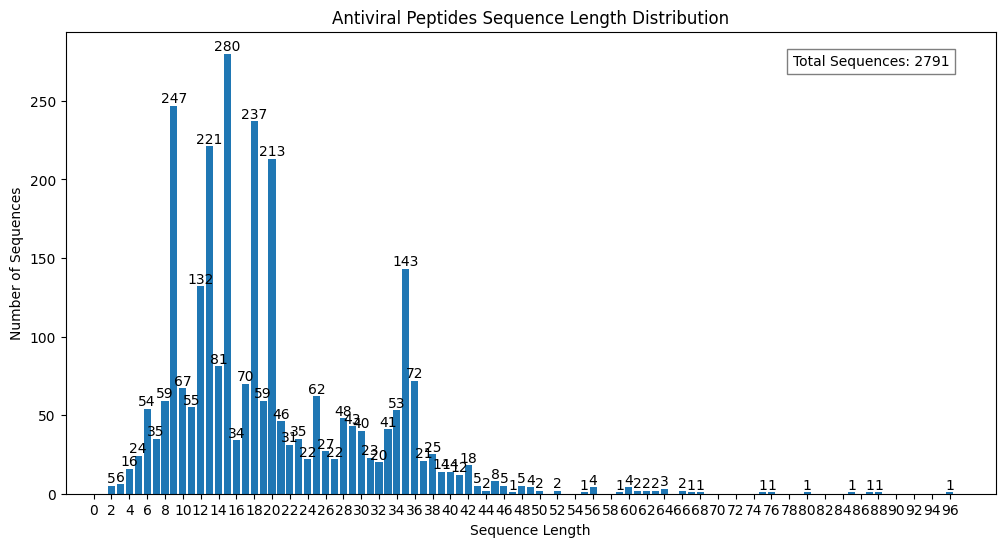

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_amino_acid_distribution(df, title):
    # Calculate the counts of each sequence length
    length_counts = df['Length'].value_counts().sort_index()

    # Create the sequence length distribution plot
    plt.figure(figsize=(12, 6))
    plt.bar(length_counts.index, length_counts.values)
    plt.xlabel('Sequence Length')
    plt.ylabel('Number of Sequences')
    plt.title(title)

    # Set x-axis ticks to every 2 amino acid lengths
    plt.xticks(range(0, max(length_counts.index)+1, 2))

    # Add text labels above each bar
    for i, v in zip(length_counts.index, length_counts.values):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

    # Calculate the total number of sequences
    total_sequences = df.shape[0]

    # Add a text label for the total number of sequences
    plt.text(0.95, 0.95, f'Total Sequences: {total_sequences}',
             ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(f'{title}.png', dpi=1000)
    plt.show()

# Extract sequence rows from df_AVPdb_extracted
sequences_AVPdb = df_AVPdb_extracted['Sequence']

# Extract sequence rows from df_dravp_extracted
sequences_dravp = df_dravp_extracted['Sequence']

# Merge sequences and remove duplicates
merged_sequences = pd.concat([sequences_AVPdb, sequences_dravp], ignore_index=True).drop_duplicates()

# Calculate the length of each sequence
lengths = merged_sequences.str.len()

# Create a DataFrame with the lengths
merged_df = pd.DataFrame({'Sequence': merged_sequences, 'Length': lengths})

# Plot the amino acid distribution for merged DataFrame
plot_amino_acid_distribution(merged_df, 'Antiviral Peptides Sequence Length Distribution')


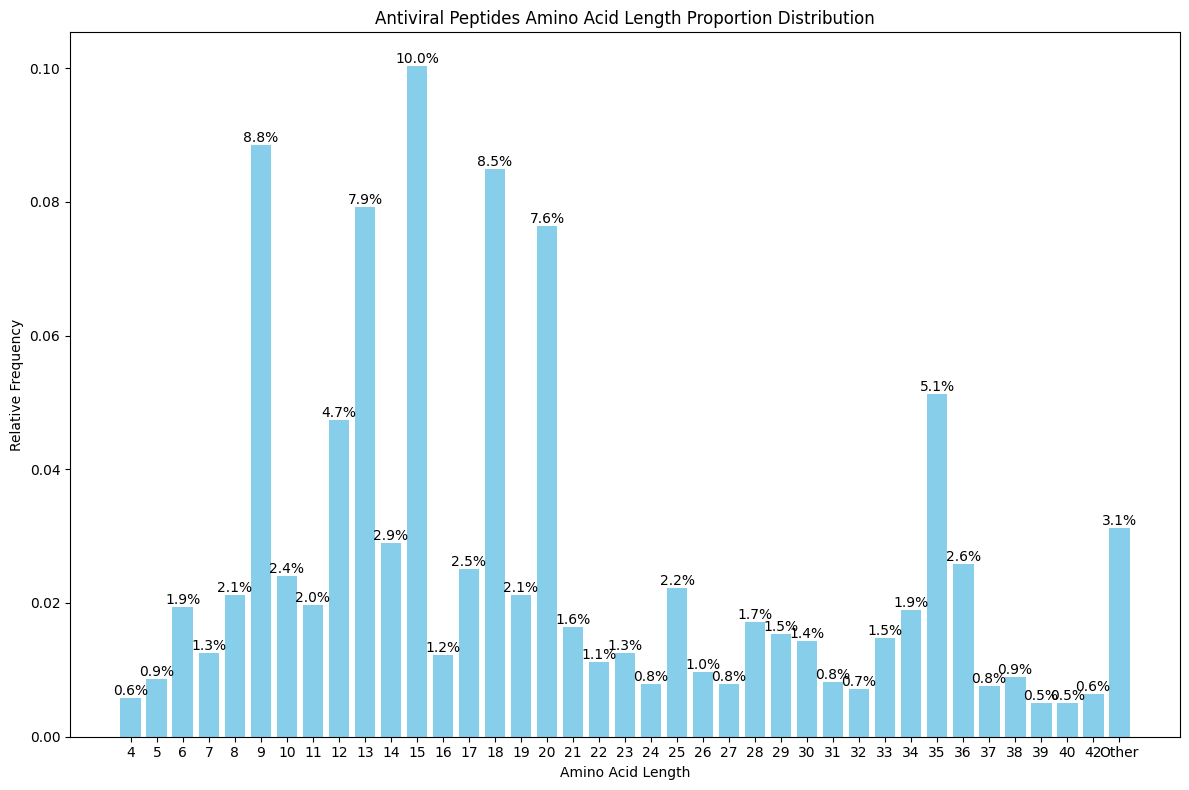

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

length_series = merged_df['Length']

length_counts = length_series.value_counts(normalize=True).sort_index()

threshold = 0.005
other_lengths = length_counts[length_counts < threshold].index
other_length_counts = length_counts[length_counts < threshold].sum()
length_counts = length_counts[length_counts >= threshold]
length_counts['Other'] = other_length_counts

length_counts.index = length_counts.index.astype(str)

plt.figure(figsize=(12, 8))
bars = plt.bar(length_counts.index, length_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1%}', ha='center', va='bottom')

plt.xlabel('Amino Acid Length')
plt.ylabel('Relative Frequency')
plt.title('Antiviral Peptides Amino Acid Length Proportion Distribution')
plt.xticks()

plt.tight_layout()
plt.show()

## **1.3 Retain sequences of length 4-42**

                                        Sequence  Length
2582                                        GVHG       4
787                                         RRKK       4
1946                                        SLDC       4
1945                                        SKHS       4
1944                                        SAHS       4
...                                          ...     ...
1047  PPDGCNRPQQSRKPPPRCLICLMVGLIHLNKIRIRAREIYES      42
1045  PPGKQHTPTSFTHPPPADILLPLSAMIHLNKIRIRAREIYES      42
1379  PPVYTKDVDISSQISSMNQSLQQSKDYIKEAQKILDTVNPSL      42
1850  SLDQINVTFLDLEYEMKKLEEAIKKLEESYIDLKELGSGSGC      42
3364  CGGGGGSLTEINTELLDLEYEMKKLEEVVKKLEESYIDLKEL      42

[2716 rows x 2 columns]


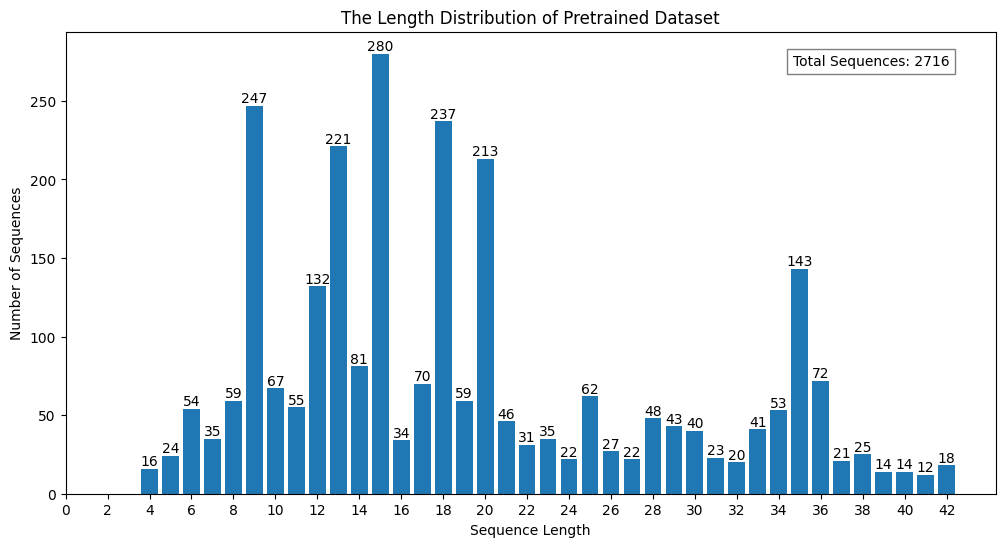

In [50]:
# Filter rows with length between 4 and 42
merged_df_filtered = merged_df[(merged_df['Length'] >= 4) & (merged_df['Length'] <= 42)]

# Sort by sequence length
merged_df_filtered_sorted = merged_df_filtered.sort_values(by='Length')

# Print the filtered DataFrame
print(merged_df_filtered_sorted)

# Save merged DataFrame to CSV file
merged_df_filtered_sorted.to_csv('Antiviral_pretrain_dataset.csv', index=False)

# Plot the amino acid distribution for merged DataFrame
plot_amino_acid_distribution(merged_df_filtered, 'The Length Distribution of Pretrained Dataset')

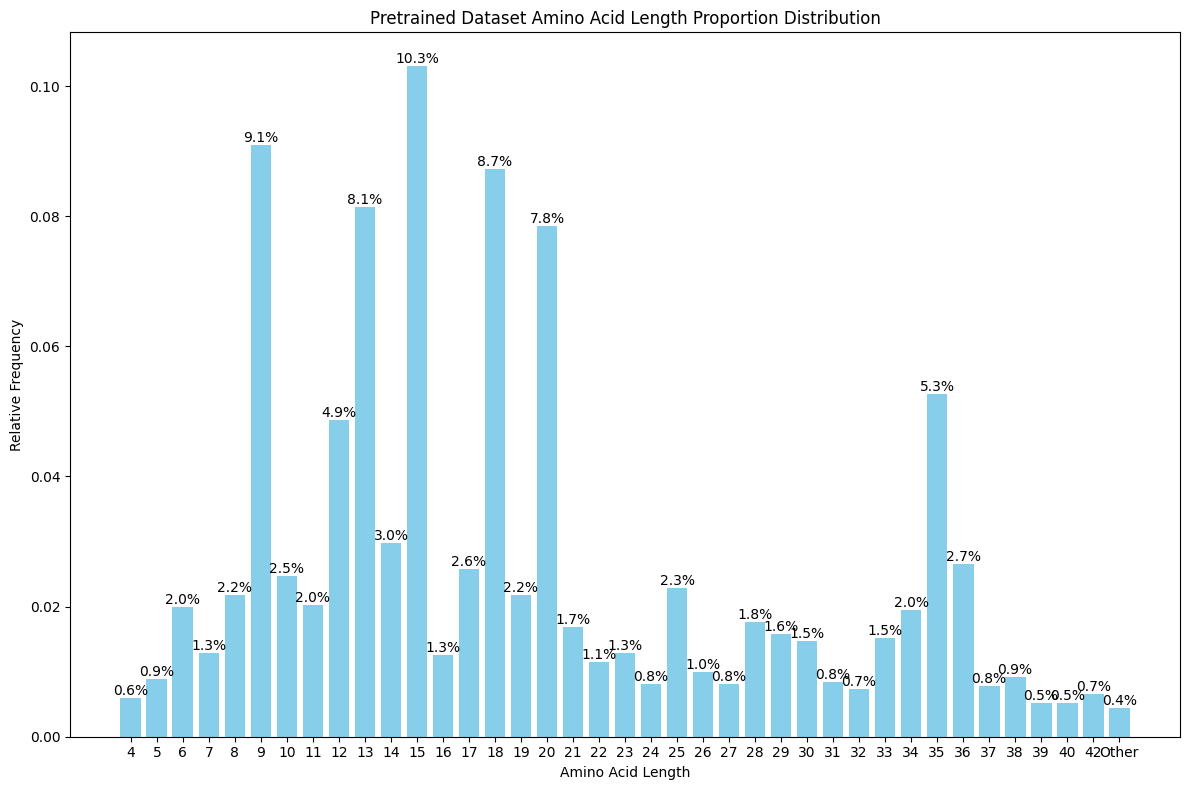

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

length_series = merged_df_filtered['Length']

length_counts = length_series.value_counts(normalize=True).sort_index()

threshold = 0.005
other_lengths = length_counts[length_counts < threshold].index
other_length_counts = length_counts[length_counts < threshold].sum()
length_counts = length_counts[length_counts >= threshold]
length_counts['Other'] = other_length_counts

length_counts.index = length_counts.index.astype(str)

plt.figure(figsize=(12, 8))
bars = plt.bar(length_counts.index, length_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1%}', ha='center', va='bottom')

plt.xlabel('Amino Acid Length')
plt.ylabel('Relative Frequency')
plt.title('Pretrained Dataset Amino Acid Length Proportion Distribution')
plt.xticks()

plt.tight_layout()
plt.savefig('Pretrained Dataset Amino Acid Length Proportion Distribution.png', dpi=1000)
plt.show()

# **2. NS3 fine-tuning dataset**

In [10]:
import pandas as pd

df_AVPdb_NS3 = df_AVPdb_extracted[
    (df_AVPdb_extracted['Family'] == 'Flaviviridae') &
    ((df_AVPdb_extracted['Target'] == 'NS2/3 protease')|
     (df_AVPdb_extracted['Target'] == 'NS3 protease')|
     (df_AVPdb_extracted['Target'] == 'Replication') )
].copy()

df_AVPdb_NS3['Length'] = df_AVPdb_NS3['Sequence'].apply(len)
df_AVPdb_NS3 = df_AVPdb_NS3.sort_values(by='Length')
df_AVPdb_NS3 = df_AVPdb_NS3.drop_duplicates(subset='Sequence')
print(df_AVPdb_NS3)

           Id                                Sequence              Virus  \
633   AVP0634                                   NQVGD  Hepatitis C virus   
627   AVP0628                                   RGIYR  Hepatitis C virus   
628   AVP0629                                   SQVGD  Hepatitis C virus   
1197  AVP1200                                  CGYGLC     Dengue 2 virus   
331   AVP0332                                  DEVVCC  Hepatitis C virus   
...       ...                                     ...                ...   
1061  AVP1062      MSTNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGV  Hepatitis C virus   
1060  AVP1061     MSTNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVY  Hepatitis C virus   
1059  AVP1060    MSTNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVYL  Hepatitis C virus   
1218  AVP1222    RQIKINFQNRRMKNKKGELDELVYLLDGPGYDPIHS  Hepatitis C virus   
1807  AVP1811  GICRCICGRGICRCICGRIGGRVPGVGVPGVGHHHHHH     Dengue 2 virus   

            Family Inhibition/IC50     Unit        Target  Length  
633   Flaviviridae 

In [11]:
df_dravp_NS3 = df_dravp_extracted[
    (df_dravp_extracted['Family'] == 'Flaviviridae') &
     (df_dravp_extracted['Binding_Target'] == 'NS3 protease')|
     (df_dravp_extracted['Binding_Target'] == 'NS2B-NS3 protease')].copy()


df_dravp_NS3['Length'] = df_dravp_NS3['Sequence'].apply(len)
df_dravp_NS3 = df_dravp_NS3.sort_values(by='Length')
df_dravp_NS3 = df_dravp_NS3.drop_duplicates(subset='Sequence')
print(df_dravp_NS3)

         DRAVP_ID          Sequence Target_Organism        Family  \
1840  DRAVPe01840          GKRKSFCA            DENV  Flaviviridae   
1838  DRAVPe01838          GKRKSGAA            DENV  Flaviviridae   
1837  DRAVPe01837          GKRKSGCA            DENV  Flaviviridae   
1146  DRAVPe00964       ADLEVVAATYV             HCV  Flaviviridae   
1224  DRAVPe01042     KKKKVVAPTYFLV             HCV  Flaviviridae   
...           ...               ...             ...           ...   
1153  DRAVPe00971    ADLEVVAATYVDDA             HCV  Flaviviridae   
1159  DRAVPe00977    KKKKVVAATYVLVF             HCV  Flaviviridae   
1135  DRAVPe00953    DDSVVCAAMSYSYA             HCV  Flaviviridae   
1255  DRAVPe01073  AKDLEVVTSTYVLVEA             HCV  Flaviviridae   
1256  DRAVPe01074  AKDLEVVCSTYVLVEA             HCV  Flaviviridae   

                                               Activity     Binding_Target  \
1840  [Ref.28539222]dengue virus 2(DENV2):inhibition...  NS2B-NS3 protease   
1838  [Ref.2853

In [12]:
import pandas as pd

# Read the Excel file and select specified columns
df_DENV = process_excel_file('/content/ADPDB_all_data.xlsx', 'Sequence')
columns_to_keep = ['ADPDB_ID', 'Sequence', 'Length', 'Target organism with strain',
                   'Inhibition concentration information', 'Target component information', 'Target process information']
df_DENV = df_DENV[columns_to_keep]

# Filter for rows containing 'ns3', 'NS3', or 'protease' (case-insensitive)
df_DENV_NS3 = df_DENV[df_DENV['Target component information'].str.contains('ns3|NS3|protease', case=False, na=False)]

# Filter for sequences with length between 4 and 42
df_DENV_NS3 = df_DENV_NS3[df_DENV_NS3['Length'].between(4, 42)]

# Print the results
print(df_DENV_NS3)

# Save to Excel file (optional)
df_DENV_NS3.to_excel('df_DENV_NS3.xlsx', index=False)

     ADPDB_ID                                  Sequence Length  \
34    ADPDB35                               PCRARIYGGCA     11   
46    ADPDB47                                     CKRKC      5   
51    ADPDB52    GICRCICGRGICRCICGRIGGRVPGVGVPGVGHHHHHH     38   
149  ADPDB150             GLPVCGETCVGGTCNTPGCTCSWPVCTRN     29   
161  ADPDB162                                    RTSKKR      6   
200  ADPDB201                          RLVYLLDGPGYDPIHC     16   
201  ADPDB202                           CYGGRLRVRRGRCPR     15   
267  ADPDB268                                     KRRRK      5   
324  ADPDB325  GFGCNGPWDEDDMQCHNHCKSIKGYKGGYCAKGGFVCKCY     40   
329  ADPDB330                                      SKKR      4   
342  ADPDB343      GFGCPLDQMQCHNHCQSVRYRGGYCTNFLKMTCKCY     36   

    Target organism with strain  \
34                       DENV-2   
46                       DENV-2   
51                       DENV-2   
149                      DENV-2   
161                      DENV-2 

In [13]:
import pandas as pd

df_merged_1 = pd.merge(df_AVPdb_NS3, df_dravp_NS3, how='outer', on='Sequence')

df_NS3 = pd.merge(df_merged_1, df_DENV_NS3, how='outer', on='Sequence')

df_NS3 = df_NS3.groupby('Sequence').first().reset_index()

df_NS3 = df_NS3.sort_values(by='Length', ascending=True)

df_NS3 = df_NS3[~((df_NS3['Inhibition/IC50'].astype(str) == '0') & (df_NS3['Unit'] == '%'))]

df_NS3_sequences = df_NS3[['Sequence']].copy()

df_NS3_sequences.loc[:, 'Length'] = df_NS3_sequences['Sequence'].apply(len)

df_NS3_sequences = df_NS3_sequences.sort_values(by='Length', ascending=True)

df_NS3_sequences.to_csv('NS3_finetune_dataset.csv', index=False)

print(df_NS3_sequences)


                                     Sequence  Length
255                                      SKKR       4
36                                      CKRKC       5
229                                     KRRRK       5
256                                     SQVGD       5
240                                     RGIYR       5
..                                        ...     ...
68       GFGCPLDQMQCHNHCQSVRYRGGYCTNFLKMTCKCY      36
232      MSTNPKPQRKTKRNTNRRPQDVKFPGGGQIVGGVYL      36
246      RQIKINFQNRRMKNKKGELDELVYLLDGPGYDPIHS      36
69     GICRCICGRGICRCICGRIGGRVPGVGVPGVGHHHHHH      38
67   GFGCNGPWDEDDMQCHNHCKSIKGYKGGYCAKGGFVCKCY      40

[185 rows x 2 columns]


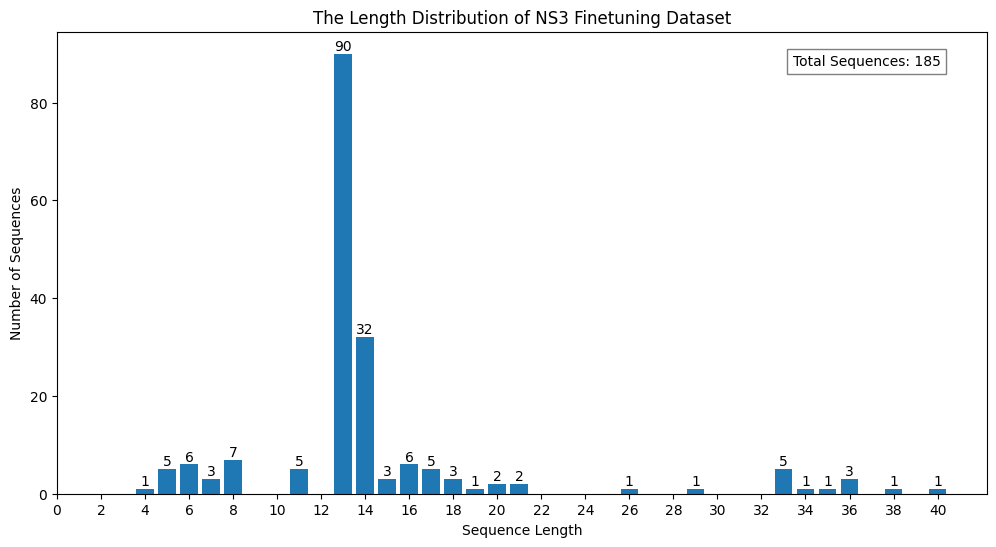

In [51]:
plot_amino_acid_distribution(df_NS3_sequences, 'The Length Distribution of NS3 Finetuning Dataset')

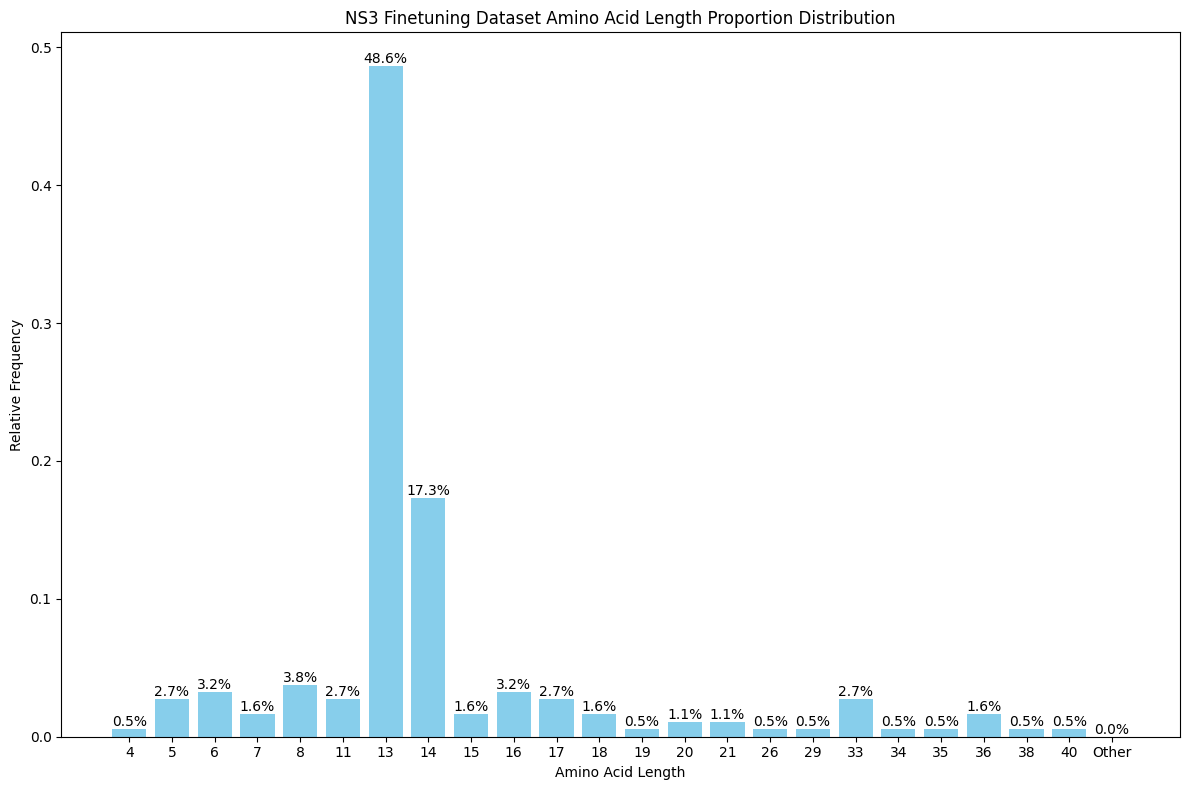

In [44]:
import pandas as pd
import matplotlib.pyplot as plt


length_series = df_NS3_sequences['Length']

length_counts = length_series.value_counts(normalize=True).sort_index()

threshold = 0.005
other_lengths = length_counts[length_counts < threshold].index
other_length_counts = length_counts[length_counts < threshold].sum()
length_counts = length_counts[length_counts >= threshold]
length_counts['Other'] = other_length_counts

length_counts.index = length_counts.index.astype(str)

plt.figure(figsize=(12, 8))
bars = plt.bar(length_counts.index, length_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1%}', ha='center', va='bottom')

plt.xlabel('Amino Acid Length')
plt.ylabel('Relative Frequency')
plt.title('NS3 Finetuning Dataset Amino Acid Length Proportion Distribution')
plt.xticks()

plt.tight_layout()
plt.savefig('NS3 Finetuning Dataset Amino Acid Length Proportion Distribution.png', dpi=1000)
plt.show()

# **3. Comparison of pretrained dataset, NS3 fine-tuning dataset, and generated peptides dataset**

## **3.1 Amino acid distribution**

### 3.1.1 Amino acid distribution in pre training dataset

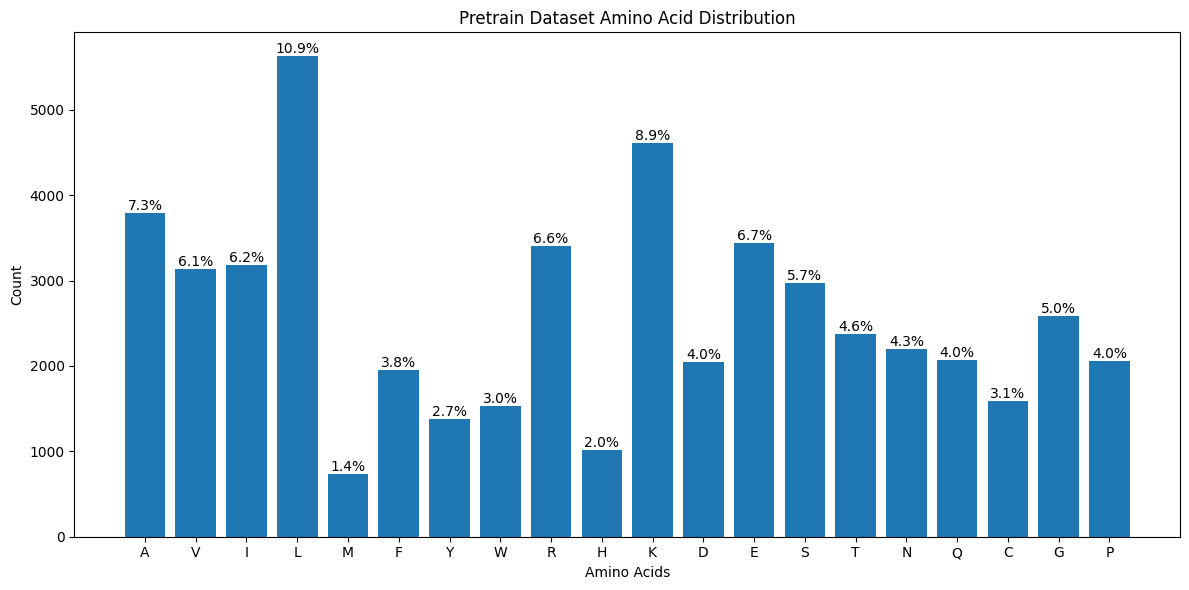

Top 5 amino acids and their relative proportions:
L: 10.88%
K: 8.92%
A: 7.33%
E: 6.67%
R: 6.58%


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def AnalyzeComposition(seq_list:list) -> np.ndarray:
    """
    Returns array with counts of each amino acid.
    """
    AA_list = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
    aa_counts = np.zeros(len(AA_list))

    for idx, aa in enumerate(AA_list):
        for seq in seq_list:
            aa_counts[idx] = aa_counts[idx] + seq.count(aa)
    return aa_counts

pretrain_df_list = merged_df_filtered_sorted.Sequence.values.tolist()
pretrain_df_list_counts = AnalyzeComposition(pretrain_df_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

total_count = np.sum(pretrain_df_list_counts)
percentages = (pretrain_df_list_counts / total_count) * 100

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(aa_labels, pretrain_df_list_counts)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentages[i]:.1f}%',
            ha='center', va='bottom', rotation=0)

plt.title('Pretrain Dataset Amino Acid Distribution')
plt.xlabel('Amino Acids')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Pretrain Dataset Amino Acid Distribution.png', dpi=1000)
plt.show()

top_indices = np.argsort(percentages)[::-1][:5]
top_aa = [aa_labels[i] for i in top_indices]
top_proportions = [percentages[i] for i in top_indices]

print("Top 5 amino acids and their relative proportions:")
for aa, proportion in zip(top_aa, top_proportions):
    print(f"{aa}: {proportion:.2f}%")

### 3.1.2 NS3 fine-tuning dataset amino acid distribution

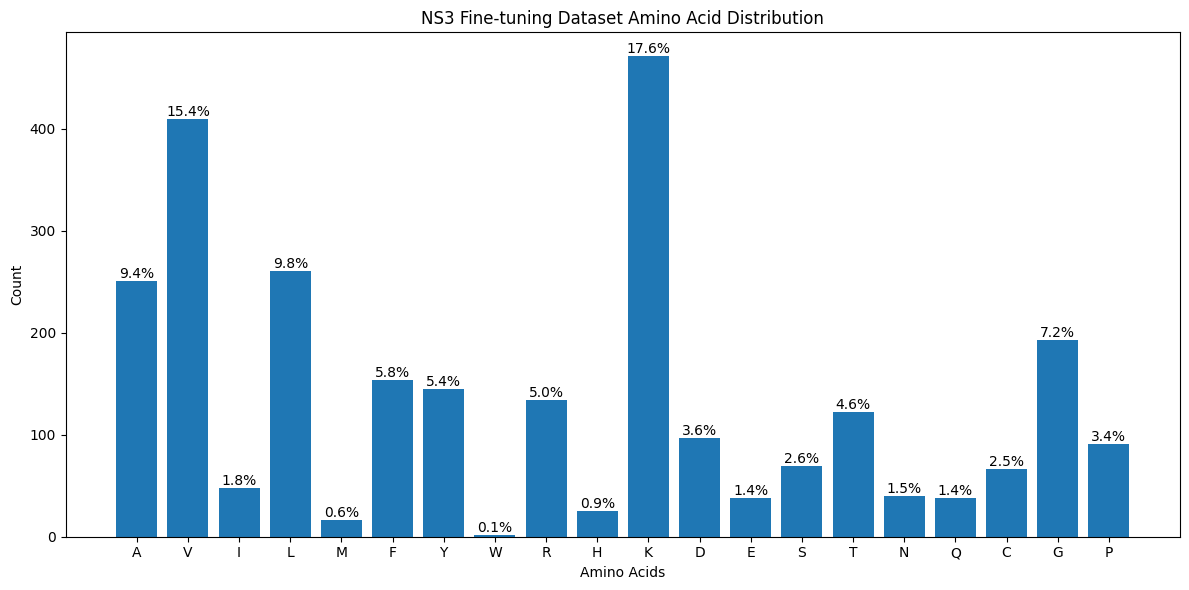

Top 5 amino acids and their relative proportions:
K: 17.63%
V: 15.35%
L: 9.77%
A: 9.40%
G: 7.23%


In [46]:
finetune_df_list = df_NS3_sequences.Sequence.values.tolist()
finetune_df_list_counts = AnalyzeComposition(finetune_df_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

total_count = np.sum(finetune_df_list_counts)
percentages = (finetune_df_list_counts / total_count) * 100

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(aa_labels, finetune_df_list_counts)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentages[i]:.1f}%',
            ha='center', va='bottom', rotation=0)

plt.title('NS3 Fine-tuning Dataset Amino Acid Distribution')
plt.xlabel('Amino Acids')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('NS3 Fine-tuning Dataset Amino Acid Distribution.png', dpi=1000)
plt.show()

top_indices = np.argsort(percentages)[::-1][:5]
top_aa = [aa_labels[i] for i in top_indices]
top_proportions = [percentages[i] for i in top_indices]

print("Top 5 amino acids and their relative proportions:")
for aa, proportion in zip(top_aa, top_proportions):
    print(f"{aa}: {proportion:.2f}%")

### 3.1.3 Generate peptides dataset amino acid distribution

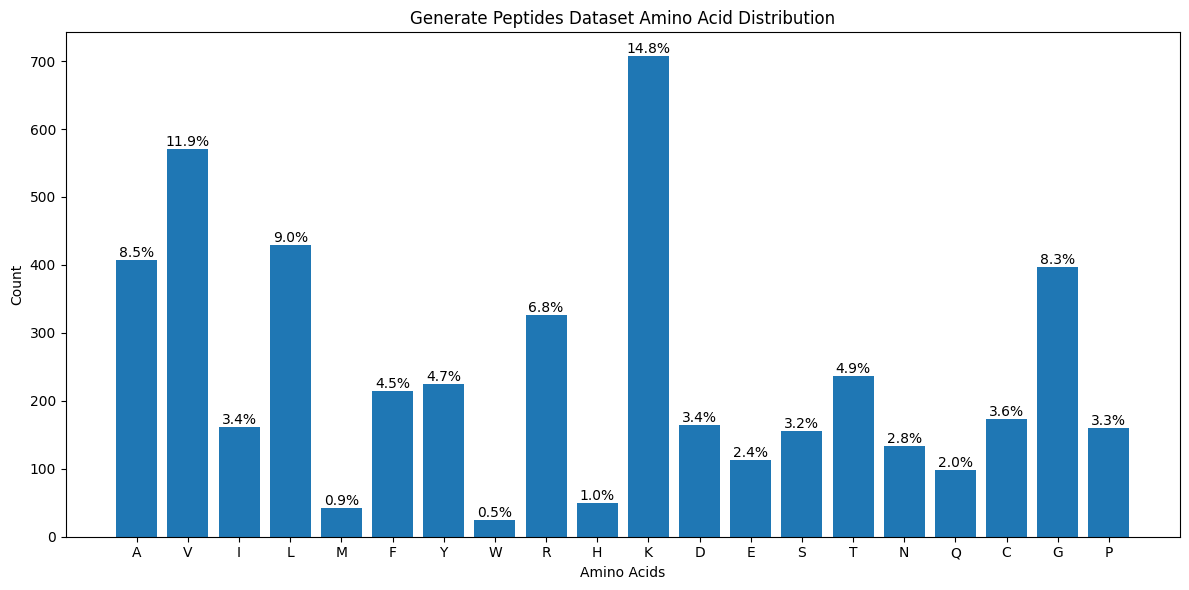

Top 5 amino acids and their relative proportions:
K: 14.77%
V: 11.93%
L: 8.96%
A: 8.52%
G: 8.29%


In [47]:
generation_df = pd.read_csv('/content/Filtered_Unique_Novel.csv', header=None)
generation_df_list = generation_df.values.tolist()
generation_df_list = [seq for sublist in generation_df_list for seq in sublist]
generation_df_list_counts = AnalyzeComposition(generation_df_list)
aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']

total_count = np.sum(generation_df_list_counts)
percentages = (generation_df_list_counts / total_count) * 100

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(aa_labels, generation_df_list_counts)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentages[i]:.1f}%',
            ha='center', va='bottom', rotation=0)

plt.title('Generate Peptides Dataset Amino Acid Distribution')
plt.xlabel('Amino Acids')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Generate Peptides Dataset Amino Acid Distribution.png', dpi=1000)
plt.show()

top_indices = np.argsort(percentages)[::-1][:5]
top_aa = [aa_labels[i] for i in top_indices]
top_proportions = [percentages[i] for i in top_indices]

print("Top 5 amino acids and their relative proportions:")
for aa, proportion in zip(top_aa, top_proportions):
    print(f"{aa}: {proportion:.2f}%")

## **3.2 Average distribution of amino acids**

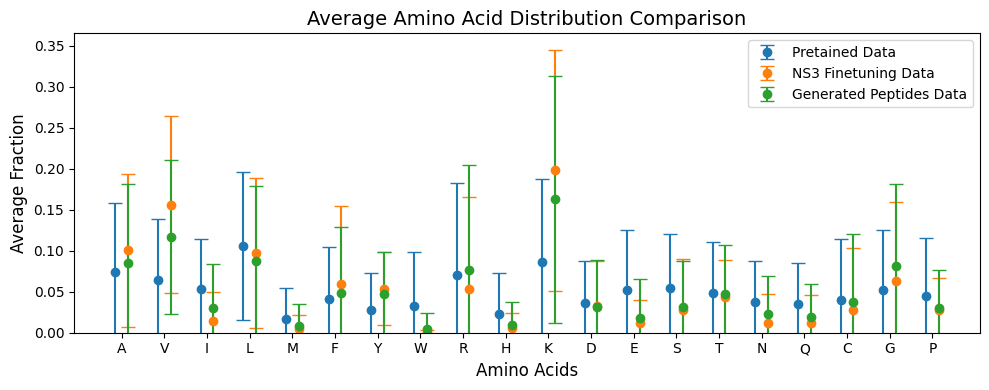

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def AnalyzeCompositionFraction(seq_list: list) -> np.ndarray:
    """
    Returns array with mean fraction of each amino acid and standard deviation.
    """
    AA_list = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
    fracs_aa = np.zeros(len(seq_list))
    fracs_mean = np.zeros(len(AA_list))
    fracs_std = np.zeros(len(AA_list))

    for i, aa in enumerate(AA_list):
        for j, seq in enumerate(seq_list):
            fracs_aa[j] = seq.count(aa)/len(seq)
        fracs_mean[i] = np.mean(fracs_aa)
        fracs_std[i] = np.std(fracs_aa)

    return fracs_mean, fracs_std


aa_labels = ['A','V', 'I', 'L', 'M', 'F', 'Y', 'W', 'R', 'H', 'K', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P']
x_pos = np.arange(len(aa_labels))

pretrain_df_mean, pretrain_df_std = AnalyzeCompositionFraction(pretrain_df_list)
finetune_df_mean, finetune_df_std = AnalyzeCompositionFraction(finetune_df_list)
generation_df_mean, generation_df_std = AnalyzeCompositionFraction(generation_df_list)

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(x_pos-0.15, pretrain_df_mean, yerr=pretrain_df_std, fmt='o', capsize=5, label = "Pretained Data")
ax.errorbar(x_pos+0.15, finetune_df_mean, yerr=finetune_df_std, fmt='o', capsize=5, label = "NS3 Finetuning Data")
ax.errorbar(x_pos+0.15, generation_df_mean, yerr=generation_df_std, fmt='o', capsize=5, label = "Generated Peptides Data")
ax.set_xticks(x_pos)
ax.set_xticklabels(aa_labels)
ax.set_ylim(ymin=0)
plt.legend()

# Adding axis labels and title
ax.set_xlabel('Amino Acids', fontsize=12)
ax.set_ylabel('Average Fraction', fontsize=12)
ax.set_title('Average Amino Acid Distribution Comparison', fontsize=14)

plt.legend()
plt.tight_layout()

plt.savefig('Average Amino Acid Distribution Comparison.png', dpi=1000, bbox_inches='tight')
plt.show()